# Task 3 Classification 

#### Group: B (Joseph Weibel / Rebecka Fahrni)

In [57]:
from datasets import load_dataset
from transformers import BertTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import torch
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from skmultilearn.model_selection import IterativeStratification
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, multilabel_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
import re


In [3]:
data = load_dataset('argilla/medical-domain')['train']
df = data.to_pandas()

# add label and text length
df['labels'] = df.prediction.apply(lambda x: x[0]['label'])
df = df.set_index('text')
df.shape


(4966, 13)

In [4]:
df_ohe = pd.get_dummies(df['labels'])
df_ohe = df_ohe.groupby(df_ohe.index).sum()
df_ohe.shape

(2357, 40)

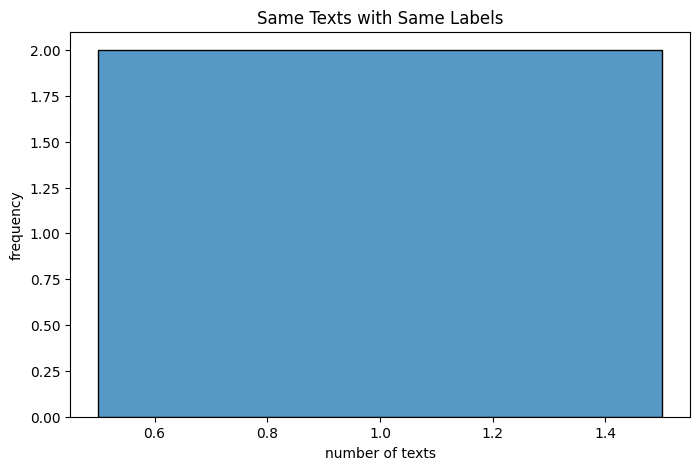

In [44]:
df_duplicate_labels = (df_ohe > 1).sum(axis=1)
df_duplicate_labels = df_duplicate_labels[df_duplicate_labels > 0]
plt.figure(figsize=(8, 5))
sns.histplot(df_duplicate_labels)
plt.title('Same Texts with Same Labels')
plt.xlabel('number of texts')
plt.ylabel('frequency')
plt.show()

In [45]:
df_ohe = df_ohe.clip(upper=1)

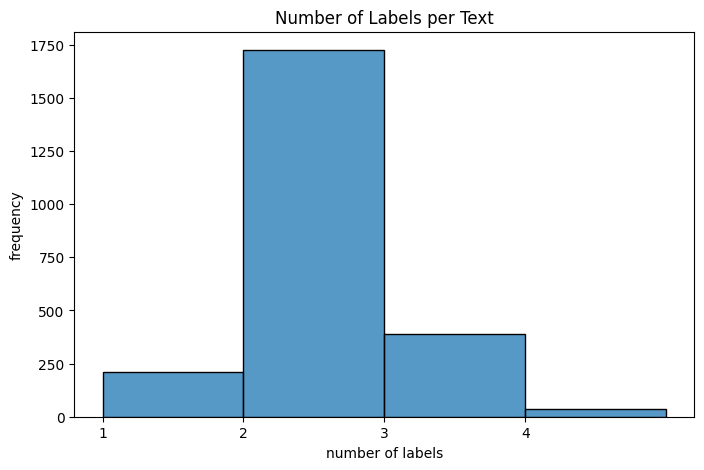

In [46]:
plt.figure(figsize=(8, 5))
sns.histplot(df_ohe.sum(axis=1), binwidth=1)
plt.title('Number of Labels per Text')
plt.xlabel('number of labels')
plt.ylabel('frequency')
plt.xticks([1, 2, 3, 4])
plt.show()

## Evaluation

In [47]:
k_fold = IterativeStratification(n_splits=3, order=1) # random_state=10

## Baseline

In [48]:
# sw = set(stopwords.words('english'))
# lemmatizer = WordNetLemmatizer()

# texts = df_ohe.index.str.lower()
# texts = [word_tokenize(text) for text in texts]
# texts = [[lemmatizer.lemmatize(word) for word in text if word not in sw] for text in texts]
# texts = [[text for word in text if re.match('[a-z]', word)] for text in texts]
# texts

In [61]:
# lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

# pipeline = Pipeline([
# 	['tfidf', TfidfVectorizer(
# 		min_df=3,
# 		max_df=0.95,
# 		lowercase=True,
# 		preprocessor=lemmatizer.lemmatize,
# 		stop_words=[lemmatizer.lemmatize(word) for word in stopwords.words('english')]
# 	)],
# 	['nb', MultiOutputClassifier(MultinomialNB())]
# ])

# cross_val_score(pipeline, df_ohe.index, df_ohe.values, cv=k_fold, n_jobs=-1, scoring='f1_macro')

# conf_matrix = np.zeros((df_ohe.shape[1], 2, 2))
f1_scores = np.zeros(df_ohe.shape[1])
for train_idx, test_idx in k_fold.split(df_ohe.index, df_ohe.values):
	X_train, X_test = df_ohe.index[train_idx], df_ohe.index[test_idx]
	Y_train, Y_test = df_ohe.values[train_idx], df_ohe.values[test_idx]

	vectorizer = TfidfVectorizer(
		min_df=3,
		max_df=0.5,
		lowercase=True,
		preprocessor=stemmer.stem,
		stop_words=[stemmer.stem(word) for word in stopwords.words('english')]
	)
	X_train_transformed = vectorizer.fit_transform(X_train)
	X_test_transformed = vectorizer.transform(X_test)

	model = MultiOutputClassifier(MultinomialNB())
	model.fit(X_train_transformed, Y_train)
	Y_pred = model.predict(X_test_transformed)

	# conf_matrix += multilabel_confusion_matrix(Y_test, Y_pred)

	# f1_scores = np.zeros(Y_test.shape[1])
	# for idx in range(Y_test.shape[1]):
	# 	f1_scores[idx] = f1_score(Y_test, Y_pred, pos_label=idx)

	# print(f1_scores.mean())
	# print(confusion_matrix(Y_test, Y_pred))
	print(f1_score(Y_test, Y_pred, average=None))
# print(conf_matrix)

/Users/joseph.weibel@fhnw.ch/.local/share/virtualenvs/Natural_Language_Processing-8K8Or-MM/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


[0.         0.         0.         0.55294118 0.         0.72206304
 0.         0.         0.         0.         0.         0.
 0.         0.         0.33333333 0.         0.         0.
 0.         0.         0.         0.         0.36956522 0.
 0.03773585 0.         0.3125     0.65536723 0.         0.
 0.         0.         0.         0.12244898 0.         0.
 0.         0.         0.94736842 0.        ]
[0.         0.         0.         0.48484848 0.         0.66852368
 0.         0.         0.         0.         0.         0.
 0.         0.         0.27906977 0.         0.         0.
 0.         0.         0.         0.         0.38709677 0.07407407
 0.07407407 0.         0.20689655 0.6        0.         0.
 0.         0.         0.         0.08247423 0.         0.
 0.         0.         0.94722598 0.        ]
[0.         0.         0.         0.5060241  0.         0.71954674
 0.         0.         0.         0.         0.         0.
 0.         0.         0.23529412 0.02272727 0.   

## BERT

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts['input_ids'])

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.texts.items()}
        item['labels'] = self.labels.iloc[idx]
        return item

In [ ]:
def train_bert_models(model_name):
	tokenizer = BertTokenizer.from_pretrained(model_name)
	model = AutoModelForSequenceClassification.from_pretrained(model_name, n_labels=df_ohe.shape[1])

	for i, (train_idx, test_idx) in enumerate(k_fold.split(df_ohe.index, df_ohe.values)):
		X_train, X_test = df_ohe.index[train_idx], df_ohe.index[test_idx]
		Y_train, Y_test = df_ohe.values[train_idx], df_ohe.values[test_idx]
		X_train_tokens = tokenizer(list(X_train), padding=True, truncation=True, max_length=256)
		X_test_tokens = tokenizer(list(X_test), padding=True, truncation=True, max_length=256)

		training_args = TrainingArguments(
			output_dir=f'./models/{model_name}/it_{i}',
			num_train_epochs=10,
			do_train=True,
			per_device_train_batch_size=32,
			learning_rate=3e-05,
			weight_decay=0.1,
			push_to_hub=False,
			logging_steps=50,
			save_total_limit=1,
		)

		trainer = Trainer(
			model=model,
			args=training_args,
			train_dataset=Dataset(X_train_tokens, Y_train),
			tokenizer=tokenizer,
		)

		trainer.train()

		prediction = trainer.predict(Dataset(X_test_tokens, Y_test))
		print(prediction.metrics)

In [ ]:
train_bert_models('bert-base-uncased')

In [ ]:
train_bert_models('dmis-lab/biobert-v1.1')

## GPT

Todo:
- Texte abschneiden (512 Tokens)
- Baseline mit TFIDF und NB/SVM
 - Preprocessing Pipeline: Snowball, lowercasing, lemmatization, Satzzeichen entfernen, Zahlen entfernen
- BERT
 - kein Preprocessing
 - bert-base-uncased, biobert, ...
- GPT
 - llama2, meditron
 - pro Label und alle Label gleichzeitig abfragen
- Evaluierung
 - 3-fach cross-validation 
 - f1-scores (pro Label und insgesamt)
- Preprocessing
 - alle Label mit weniger als 20 Texten entfernen
 - Oversampling